In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely import wkt

In [2]:
def find_parquet_files(directory):
    """
    Find all Parquet files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to Parquet files.
    """
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

In [3]:
def rasterize_dataset(dataset_path, raster_path, raster_shape, raster_transform):
    # Load the dataset
    df = pd.read_parquet(dataset_path)

    # Convert geometry data from WKT to shapely objects if necessary
    if 'geometry' in df.columns and isinstance(df['geometry'].iloc[0], str):
        df['geometry'] = df['geometry'].apply(wkt.loads)

    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:32161")

    # Rasterize
    shapes = ((geom, 1) for geom in gdf.geometry)
    rasterized = rasterize(shapes, out_shape=raster_shape, transform=raster_transform, fill=0, default_value=1, dtype='uint8')

    # Save the rasterized output
    with rasterio.open(
        raster_path, 'w', 
        driver='GTiff', 
        height=raster_shape[0], 
        width=raster_shape[1], 
        count=1, 
        dtype='uint8', 
        crs=gdf.crs, 
        transform=raster_transform
    ) as dst:
        dst.write(rasterized, 1)

In [4]:
def combine_rasters(raster_paths, output_path):
    """
    Combine multiple rasterized datasets into a single raster.

    :param raster_paths: List of paths to the rasterized datasets.
    :param output_path: Path where the combined raster will be saved.
    """
    combined_raster = None
    profile = None

    for path in raster_paths:
        with rasterio.open(path) as src:
            raster_data = src.read(1)  # Read the first band
            if combined_raster is None:
                combined_raster = raster_data
                profile = src.profile
            else:
                combined_raster = np.maximum(combined_raster, raster_data)  # Combine using maximum value

    # Modify the profile to accommodate the combined raster
    profile.update(dtype=rasterio.uint8, count=1)

    # Save the combined raster
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(combined_raster, 1)

In [5]:
def raster_to_dataframe(raster_path):
    """
    Convert a raster to a Pandas DataFrame.

    :param raster_path: Path to the raster file.
    :return: DataFrame representation of the raster.
    """
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)
    return pd.DataFrame(raster_data)

In [8]:
# Find all Parquet files in the specified directory
base_directory = '../../data/PR100'
parquet_files = find_parquet_files(base_directory)

# Define the raster shape and transformation
raster_shape = (200, 400)  # Example shape based on your grid
raster_transform = from_origin(100000, 300000, 500, 500)  # Example transform

# Paths for the rasterized outputs
raster_paths = [os.path.splitext(p)[0] + '.tif' for p in parquet_files]

# Rasterize each dataset
for dataset_path, raster_path in zip(parquet_files, raster_paths):
    rasterize_dataset(dataset_path, raster_path, raster_shape, raster_transform)

# Combine the rasterized datasets
combined_raster_path = 'combined_raster.tif'
combine_rasters(raster_paths, combined_raster_path)

# Convert the combined raster to a DataFrame
final_df = raster_to_dataframe(combined_raster_path)

In [9]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
196,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
197,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
198,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


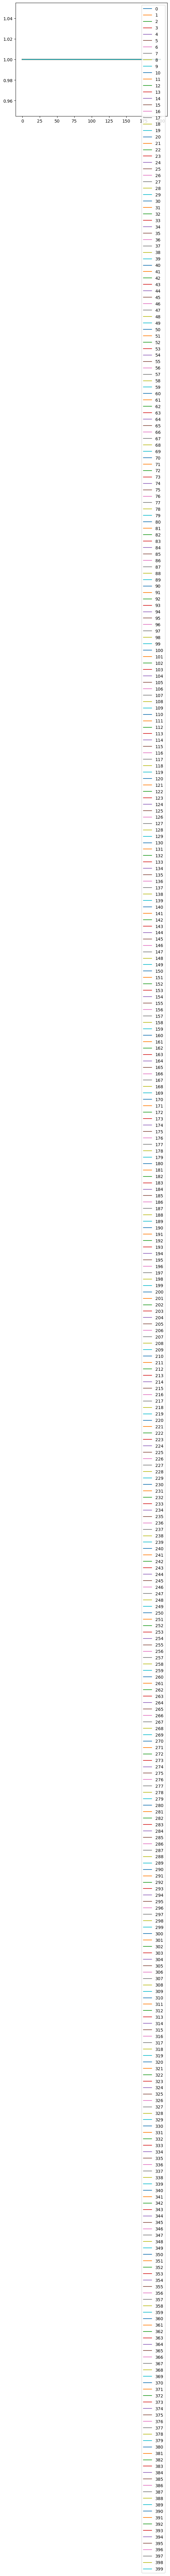

In [12]:
final_df.plot()
plt.show()